# Projet HPC - simulation de processus gaussiens


## ÉCOMPOSITION DE KARHUNEN-LOÈVE 1D

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp
import meshio

****

Davidson Lova RAZAFINDRAKOTO

****

### Question 1

Décomposition de Karhunen-Loève du processus stochastique $Z(x, \omega)$ :

$$Z(x, \omega) = \sum_{n \geq 0} \sqrt{\lambda_n} \phi_n(x) \xi_n(\omega)$$

avec $\xi_n(\omega) = \frac{1}{\lambda_n} \int_{\mathcal{J}} Z(x,\omega) \phi(x) dx$

+ $\mathbb{E}(\xi_n) = 0$
+ $\mathbb{E}(\xi_n \xi_m) = \delta_{n,m}$

et $(\lambda_n, \phi_n)$ valeur et fonction propre de $K$ (i.e. solution de $\int_{\mathcal{J}} K(x,y) \phi(y) dy = \lambda \phi(x)$)

Si on souhaite générer des trajectoire de $Z(x, \omega)$ alors on prend $\xi_n \sim \mathcal{N}(0,1)$ i.i.d.

### Question 2

Pour calculer des approximations des $(\lambda_n, \phi_n)$ on prend une disretisation régulière de l'espace $\mathcal{J}$


$$\int_{\mathcal{J}} K(x,y) \phi(y) dy = \sum_{j = 1}^{N}\int_{x_j}^{x_{j+1}} K(x,y) \phi(y) dy$$

On approxime les integralles par une quadrature point milieu, i.e.

$$ \int_{x_j}^{x_{j+1}} K(x,y) \phi(y) dy \approx  h K(x,y_{j+\frac{1}{2}}) \phi(y_{j+\frac{1}{2}})$$

Ce qui nous donne 

$$\int_{\mathcal{J}} K(x,y) \phi(y) dy \approx \sum_{j = 1}^{N}h K(x,y_{j+\frac{1}{2}}) \phi(y_{j+\frac{1}{2}}) $$


On evalue maintenant en $x = x_{i + \frac{1}{2}}$ pour $i = 1,...,N$

$$(*) \sum_{j = 1}^{N}h K(x_{i + \frac{1}{2}},y_{j+\frac{1}{2}}) \phi(y_{j+\frac{1}{2}}) = \lambda \phi(x_{i + \frac{1}{2}})$$

Soient $K \in \mathbb{R}^{N \times N}$ la matrice tel que $K_{i,j} = K(x_{i + \frac{1}{2}}, y_{j + \frac{1}{2}})$

et $\phi \in \mathbb{R}^N$ le vecteur tel que $\phi_{j} = \phi(y_{j + \frac{1}{2}})$

Ce qui nous donne $$ (*) \Longleftrightarrow h K \phi = \lambda \phi $$

La discretisation nous ramène alors au calcul des valeurs et vecteur propres de la matrice $h K$






### Question 3

Démarche de génération de trajectoire

+ Résoudre $\int_{\mathcal{J}} K(x,y) \phi(y) dy = \lambda \phi(x)$ i.e pour notre cas discret $h K \phi = \lambda \phi$

Ce qui se resout en $\Omicron(N^2)$ si on utilise un algorithme itératif mais $\Omicron(N^3)$.

+ Tonquer la série en retenant que $N_{KL}$ tq $\sum_{n = 1}^{N_{KL}} \lambda_n \sim 0.95 \sum_{n = 1}^{N} \lambda_n$

+ On tire $N_{KL}$ v.a. iid $\xi_n \sim \mathcal{N}(0,1)$
+ La trajectoire sera alors le vecteur $Z_{N_{KL}} (x_{i + \frac{1}{2}}) = \sum_{ n = 1}^{N_{KL}}\sqrt{\lambda_n} \phi_{j} \xi_n$ pour $i = 1, ..., N$

In [199]:
# Paramètre du domaine
J = [-1, 1]
N = 2000
h = 2./N
partVar = 0.95
lambdaK = 5

# Discretisation régulière de J
x = np.linspace(J[0] + h/2, J[1] - h/2, N - 2)

# Calcul de la matrice noyau
K = np.exp(-np.abs(np.subtract.outer(x, x)) / lambdaK)

# Calcul des valeurs propres et vecteur propres de la matrice h K
hK = h*K
hw, hv = np.linalg.eig(hK)

# Renormalisation
hv = hv / np.sqrt(h)

# Troncature
tracehK = sum(hw)
Nkl = sum(np.cumsum(hw) < tracehK*partVar) + 1


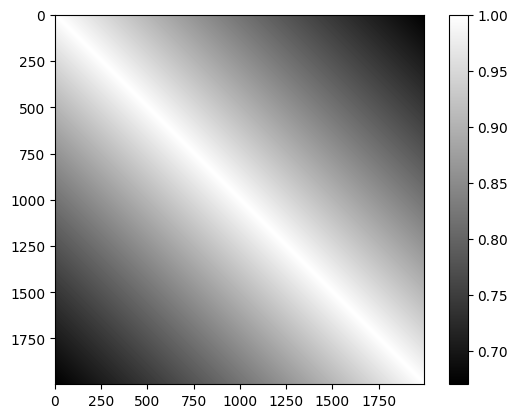

In [200]:
plt.imshow(K,  cmap= 'gray')
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Trajectoire approché avec 95.0% part de variance')

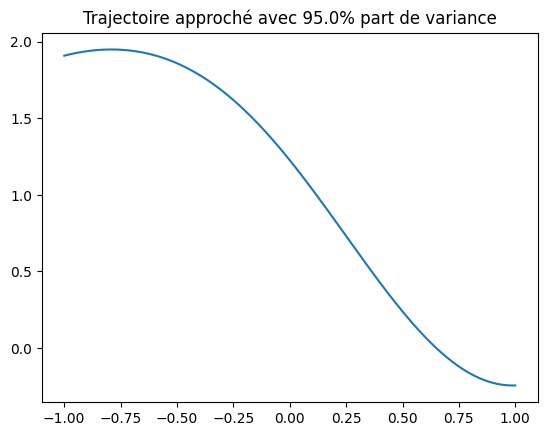

In [201]:
hwTronc = hw[:Nkl]

Xin = np.random.randn(Nkl)

cn = (np.sqrt(hwTronc)*Xin).reshape(Nkl, 1)

Phin = hv[:, :Nkl]

ZNkl = np.matmul(Phin, cn)

plt.plot(x, ZNkl)
plt.title("Trajectoire approché avec {}% part de variance".format(partVar*100))


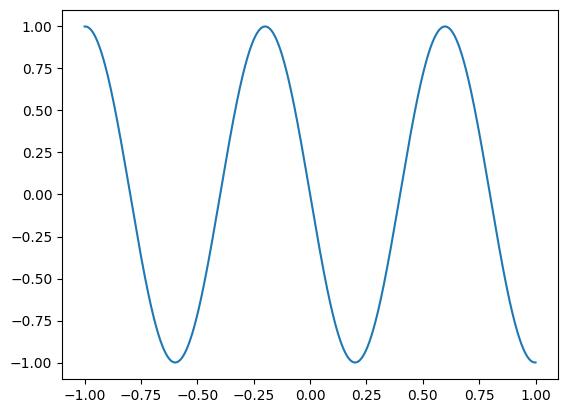

In [202]:
plt.plot(x, hv[:,5])

### Question 4

$$T_K : f \mapsto \int_{\mathcal{J}} K_{\lambda} (x,y) f(y)dy$$

$f_n (x) = A_n \cos(\omega_n \frac{x}{2}) + B_n \sin(\omega_n \frac{x}{2})$


$\lambda_n = \frac{2\lambda \omega}{\lambda^2 \omega_n^2} et \tan (\omega) = \frac{2 \lambda \omega}{\lambda^2 \omega^2}$


$\int_{\mathcal{J}} K_{\lambda} (x,y) f_n(y)dy = \int_{-1}^1 K_{\lambda} (x,y) f_n(y)dy = \int_{-1}^1 e^{-\frac{|x - y|}{\lambda}} \left( A_n \cos(\omega_n \frac{y}{2}) + B_n \sin(\omega_n \frac{y}{2}) \right) dy$

$ =  A_n \int_{-1}^1 e^{-\frac{|x - y|}{\lambda}} \cos(\omega_n \frac{y}{2}) dy + B_n \int_{-1}^1 e^{-\frac{|x - y|}{\lambda}} \sin(\omega_n \frac{y}{2}) dy$

$ = A_n \int_{-1}^x e^{-\frac{|x - y|}{\lambda}} \cos(\omega_n \frac{y}{2}) dy + A_n \int_{x}^1 e^{-\frac{|x - y|}{\lambda}} \cos(\omega_n \frac{y}{2}) dy + B_n \int_{-1}^x e^{-\frac{|x - y|}{\lambda}} \sin(\omega_n \frac{y}{2}) dy + B_n \int_{x}^1 e^{-\frac{|x - y|}{\lambda}} \sin(\omega_n \frac{y}{2}) dy$

$ = A_n \int_{-1}^x e^{-\frac{x - y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy + A_n \int_{x}^1 e^{\frac{x - y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy + B_n \int_{-1}^x e^{-\frac{x - y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy + B_n \int_{x}^1 e^{\frac{x - y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy$ 

****

$ = A_n e^{-\frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy + e^{\frac{x}{\lambda}} A_n \int_{x}^1 e^{-\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy + B_n e^{-\frac{x}{\lambda}} \int_{-1}^x e^{\frac{y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy + B_n e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy$

****


$\int_{-1}^x e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy = [\lambda e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2})]_{-1}^x  + \lambda \omega_n  \frac{1}{2} \int_{-1}^x e^{\frac{y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy$

$\int_{-1}^x e^{\frac{y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy = [\lambda e^{\frac{y}{\lambda}} sin(\omega_n \frac{y}{2})]_{-1}^x - \lambda \omega_n  \frac{1}{2} \int_{-1}^x e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy$

$[\lambda e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2})]_{-1}^x  = \lambda e^{\frac{x}{\lambda}} \cos(\omega_n \frac{x}{2}) - \lambda e^{-\frac{1}{\lambda}} \cos(-\omega_n \frac{1}{2}) = \lambda e^{\frac{x}{\lambda}} \cos(\omega_n \frac{x}{2}) - \lambda e^{-\frac{1}{\lambda}} \cos(\omega_n \frac{1}{2} )$

$[\lambda e^{\frac{y}{\lambda}} sin(\omega_n \frac{y}{2})]_{-1}^x = \lambda e^{\frac{x}{\lambda}} sin(\omega_n \frac{x}{2}) - \lambda e^{-\frac{1}{\lambda}} sin(-\omega_n \frac{1}{2}) = \lambda e^{\frac{x}{\lambda}} sin(\omega_n \frac{x}{2}) + \lambda e^{-\frac{1}{\lambda}} sin(\omega_n \frac{1}{2})$


$\int_{-1}^x e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy = [\lambda e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2})]_{-1}^x  + \lambda\omega_n\int_{-1}^x e^{\frac{y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy $

$ = \left[ \lambda e^{\frac{x}{\lambda}} \cos(\omega_n \frac{x}{2}) - \lambda e^{-\frac{1}{\lambda}} \cos(\omega_n \frac{1}{2} ) \right] + \lambda\omega_n \frac{1}{2} \left[ \left[ \lambda e^{\frac{x}{\lambda}} sin(\omega_n \frac{x}{2}) + \lambda e^{-\frac{1}{\lambda}} sin(\omega_n \frac{1}{2}) \right] -\lambda \omega_n \frac{1}{2} \int_{-1}^x  e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy \right]$

$ = \lambda e^{\frac{x}{\lambda}} \cos(\omega_n \frac{x}{2}) - \lambda e^{-\frac{1}{\lambda}} \cos(\omega_n \frac{1}{2} ) + \lambda^2 \omega_
n  \frac{1}{2} e^{\frac{x}{\lambda}} sin(\omega_n \frac{x}{2}) + \lambda^2 \omega_
n  \frac{1}{2} e^{-\frac{1}{\lambda}} sin(\omega_n \frac{1}{2}) - \lambda^2 \omega_n^2 \frac{1}{4} \int_{-1}^x \lambda e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy$

$\int_{-1}^x e^{\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy = \frac{2\lambda}{4 + \lambda^2 \omega_n^2} \left[ 2 e^{\frac{x}{\lambda}} \cos(\omega_n \frac{x}{2}) - 2 e^{-\frac{1}{\lambda}} \cos(\frac{\omega_n}{2} ) + \lambda \omega_
n   e^{\frac{x}{\lambda}} \sin( \omega_n\frac{x}{2}) + \lambda\omega_
n   e^{-\frac{1}{\lambda}} \sin( \frac{\omega_n}{2})\right]$

$\int_{x}^1 e^{-\frac{y}{\lambda}} \cos(\omega_n \frac{y}{2}) dy = \frac{2\lambda}{ 4 + \lambda^2 \omega_n^2} \left[ 2 e^{-\frac{x}{\lambda}} \cos(\omega_n  \frac{x}{2})  - 2  e^{-\frac{1}{\lambda}} \cos(\frac{\omega_n}{2}) -\omega_n \lambda e^{- \frac{x}{\lambda}}  \sin(\omega_n \frac{x}{2})+  \omega_n \lambda e^{-\frac{1}{\lambda}} \sin( \frac{\omega_n}{2}) \right]$

$\int_{-1}^x e^{\frac{y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy = - \frac{2 \lambda}{ 4 + \lambda^2 \omega_n^2} \left[ \lambda \omega_n e^{\frac{x}{\lambda}}\cos(\omega_n \frac{x}{2}) - \lambda \omega_n e^{-\frac{1}{\lambda}} \cos( \frac{\omega_n}{2}) - 2 e^{\frac{x}{\lambda}} \sin(\omega_n \frac{x}{2}) - 2 e^{-\frac{1}{\lambda}} \sin(\frac{\omega_n}{2}
)\right]$

$\int_{x}^1 e^{- \frac{y}{\lambda}} \sin(\omega_n \frac{y}{2}) dy = - \frac{2 \lambda}{ 4 + \lambda^2 \omega_n^2} \left[ - \lambda \omega_n e^{- \frac{x}{\lambda}} \cos(\omega_n \frac{x}{2}) + \lambda \omega_n e^{- \frac{1}{\lambda}}  \cos( \frac{\omega_n}{2}) - 2 e^{- \frac{x}{\lambda}} \sin(\omega_n \frac{x}{2}) + 2 e^{ - \frac{1}{\lambda}} \sin(\frac{\omega_n}{2})\right]$

****

$ \frac{2\lambda}{4 + \lambda^2 \omega_n^2} \left[ 2  \cos(\omega_n \frac{x}{2}) - 2 e^{- \frac{x}{\lambda}} e^{-\frac{1}{\lambda}} \cos(\omega_n \frac{1}{2} ) + \lambda \omega_
n    sin(\omega_n \frac{x}{2}) + \lambda\omega_
n   e^{-\frac{1}{\lambda}} e^{- \frac{x}{\lambda}} sin(\omega_n \frac{1}{2})\right] $

$ = \frac{2\lambda}{4 + \lambda^2 \omega_n^2} \left[ 2  \cos(\omega_n \frac{x}{2}) - 2 e^{- \frac{x+1}{\lambda}} \cos(\omega_n \frac{1}{2} ) + \lambda \omega_
n    sin(\omega_n \frac{x}{2}) + \lambda\omega_
n   e^{- \frac{x+1}{\lambda}} sin(\omega_n \frac{1}{2})\right] $

****

$\frac{2\lambda}{ 4 + \lambda^2 \omega_n^2} \left[ 2  \cos(\omega_n  \frac{x}{2})  - 2  e^{-\frac{1}{\lambda}} e^{\frac{x}{\lambda}} \cos(\frac{\omega_n}{2}) -\omega_n \lambda \sin(\omega_n \frac{x}{2})+  \omega_n \lambda e^{\frac{x}{\lambda}} e^{-\frac{1}{\lambda}} \sin( \frac{\omega_n}{2}) \right]$

$ = \frac{2\lambda}{ 4 + \lambda^2 \omega_n^2} \left[ 2  \cos(\omega_n  \frac{x}{2})  - 2 e^{\frac{x - 1}{\lambda}} \cos(\frac{\omega_n}{2}) -\omega_n \lambda \sin(\omega_n \frac{x}{2})+  \omega_n \lambda e^{\frac{x-1}{\lambda}} \sin( \frac{\omega_n}{2}) \right]$

****
$ - \frac{2 \lambda}{ 4 + \lambda^2 \omega_n^2} \left[ \lambda \omega_n \cos(\omega_n \frac{x}{2}) - \lambda \omega_n e^{-\frac{x}{\lambda}} e^{-\frac{1}{\lambda}} \cos( \frac{\omega_n}{2}) - 2 \sin(\omega_n \frac{x}{2}) - 2 e^{-\frac{x}{\lambda}} e^{-\frac{1}{\lambda}} \sin(\frac{\omega_n}{2}
) \right]$

$ = \frac{2 \lambda}{ 4 + \lambda^2 \omega_n^2} \left[ - \lambda \omega_n \cos(\omega_n \frac{x}{2}) + \lambda \omega_n e^{-\frac{x+1}{\lambda}} \cos( \frac{\omega_n}{2}) + 2 \sin(\omega_n \frac{x}{2}) + 2 e^{-\frac{x+1}{\lambda}} \sin(\frac{\omega_n}{2}
) \right] $

****

$ - \frac{2 \lambda}{ 4 + \lambda^2 \omega_n^2} \left[ - \lambda \omega_n \cos(\omega_n \frac{x}{2}) + \lambda \omega_n e^{\frac{x}{\lambda}} e^{- \frac{1}{\lambda}}  \cos( \frac{\omega_n}{2}) - 2 \sin(\omega_n \frac{x}{2}) + 2 e^{\frac{x}{\lambda}}  e^{ - \frac{1}{\lambda}} \sin(\frac{\omega_n}{2})\right]$

$ =  \frac{2 \lambda}{ 4 + \lambda^2 \omega_n^2} \left[ \lambda \omega_n \cos(\omega_n \frac{x}{2}) - \lambda \omega_n e^{\frac{x-1}{\lambda}} \cos( \frac{\omega_n}{2}) + 2 \sin(\omega_n \frac{x}{2}) - 2 e^{\frac{x-1}{\lambda}} \sin(\frac{\omega_n}{2})\right] $

****
$ 2 \cos(\omega_n \frac{x}{2}) - 2 e^{- \frac{x+1}{\lambda}} \cos(\omega_n \frac{1}{2} ) + \lambda \omega_n sin(\omega_n \frac{x}{2}) + \lambda \omega_n   e^{- \frac{x+1}{\lambda}} sin(\omega_n \frac{1}{2}) + 2  \cos(\omega_n  \frac{x}{2})  - 2 e^{\frac{x - 1}{\lambda}} \cos(\frac{\omega_n}{2}) -\omega_n \lambda \sin(\omega_n \frac{x}{2})+  \omega_n \lambda e^{\frac{x-1}{\lambda}} \sin( \frac{\omega_n}{2})$

$ = 4 \cos(\omega_n \frac{x}{2}) - 2 e^{ - \frac{1}{\lambda}} (e^{-\frac{x}{\lambda}} + e^{\frac{x}{\lambda}})  \cos(\frac{\omega_n}{2} ) + \lambda \omega_n e^{-\frac{1}{\lambda}}(e^{-\frac{x}{\lambda}} + e^{\frac{x}{\lambda}}) \sin(\frac{\omega_n}{2})$

****
$- \lambda \omega_n \cos(\omega_n \frac{x}{2}) + \lambda \omega_n e^{-\frac{x+1}{\lambda}} \cos( \frac{\omega_n}{2}) + 2 \sin(\omega_n \frac{x}{2}) + 2 e^{-\frac{x+1}{\lambda}} \sin(\frac{\omega_n}{2}) + \lambda \omega_n \cos(\omega_n \frac{x}{2}) - \lambda \omega_n e^{\frac{x-1}{\lambda}} \cos( \frac{\omega_n}{2}) + 2 \sin(\omega_n \frac{x}{2}) - 2 e^{\frac{x-1}{\lambda}} \sin(\frac{\omega_n}{2}) $

$ =  \lambda \omega_n e^{- \frac{1}{\lambda}} (e^{\frac{x}{\lambda}} - e^{-\frac{x}{\lambda}}) \cos(\frac{\omega_n }{2}) + 4 \sin (\omega_n \frac{x}{2}) - 2 e^{-\frac{1}{\lambda}}(e^{\frac{x}{\lambda}} - e^{-\frac{x}{\lambda}}) \sin(\frac{\omega_n}{2})$

****
$ 4 (A_n \cos(\omega_n \frac{x}{2}) + B_n \sin(\omega_n \frac{x}{2})) + \lambda \omega_n e^{-\frac{1}{\lambda}}(e^{-\frac{x}{\lambda}} + e^{\frac{x}{\lambda}}) (A_n \sin(\frac{\omega_n}{2}) - B_n \cos(\frac{\omega_n}{2})) +  2 e^{ - \frac{1}{\lambda}} (e^{-\frac{x}{\lambda}} + e^{\frac{x}{\lambda}})  (- A_n \cos(\frac{\omega_n}{2}) + B_n \sin(\frac{\omega_n}{2}))$

$ = 4 (A_n \cos(\omega_n \frac{x}{2}) - B_n \sin(\omega_n \frac{x}{2})) + e^{-\frac{1}{\lambda}}(e^{-\frac{x}{\lambda}} + e^{\frac{x}{\lambda}}) (A_n (\lambda \omega_n \sin(\frac{\omega_n}{2}) - 2 \cos(\frac{\omega_n}{2} )) + B_n (- \lambda \omega_n \cos(\frac{\omega_n}{2}) + 2 \sin(\frac{\omega_n}{2}))) $

## CHAMP GAUSSIEN SUR UN DOMAINE DE $\mathbb{R}^2$

### Question 1 (Génération du maillage)

In [203]:
Jn = np.array([[-1, 1], [-1, 1]])
Nx = 10
Ny = 10

dx = np.linspace(Jn[0][0], Jn[0][1], Nx)
dy = np.linspace(Jn[1][0], Jn[1][1], Ny)

X = np.outer(dx, np.ones(Ny))
Y = np.outer(dy, np.ones(Nx))

points = np.concatenate(
    (X.ravel().reshape(Nx*Ny, 1), Y.transpose().ravel().reshape(Nx*Ny, 1)), 1)

tri = sp.Delaunay(points)


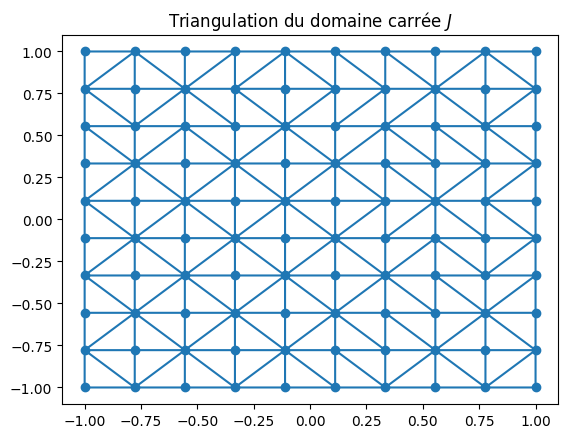

In [204]:
plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.scatter(points[:, 0], points[:, 1])
plt.title(f"Triangulation du domaine carrée $J$")
plt.show()


### Question 2 (Décomposition de Karhunen-Loève)

Décomposition de Karhunen-Loève du champ stochastique $Z(\textit{\textbf{x}}, \omega)$ :

$$Z(\textit{\textbf{x}}, \omega) = \sum_{n \geq 0} \sqrt{\lambda_n} \phi_n(\textit{\textbf{x}}) \xi_n(\omega)$$

avec $\xi_n(\omega) = \frac{1}{\lambda_n} \int_{\mathcal{J}} Z(\textit{\textbf{x}},\omega) \phi(\textit{\textbf{x}}) d\textit{\textbf{x}}$

+ $\mathbb{E}(\xi_n) = 0$
+ $\mathbb{E}(\xi_n \xi_m) = \delta_{n,m}$

et $(\lambda_n, \phi_n)$ valeur et fonction propre de $K$ (i.e. solution de $\int_{\mathcal{J}} K(\textit{\textbf{x}},\textit{\textbf{y}}) \phi(\textit{\textbf{y}}) d\textit{\textbf{y}} = \lambda \phi(\textit{\textbf{x}})$)

Si on souhaite générer des trajectoire de $Z(\textit{\textbf{x}}, \omega)$ alors on prend $\xi_n \sim \mathcal{N}(0,1)$ i.i.d.


$$\int_{\mathcal{J}} K(\textit{\textbf{x}},\textit{\textbf{y}}) \phi(\textit{\textbf{y}}) d\textit{\textbf{y}} = \sum_{T_k \in D_h}\int_{T_k} K(\textit{\textbf{x}},\textit{\textbf{y}}) \phi(\textit{\textbf{y}}) d\textit{\textbf{y}}  \approx \sum_{T_k \in D_h} |T_k| K(\textit{\textbf{x}},\textit{\textbf{y}}_k) \phi(\textit{\textbf{y}}_k) $$

On résout alors le problème suivant pour tout $\textit{\textbf{x}}_l$ barycentre de $T_l \in D_h$

$$(*) \sum_{T_k \in D_h} |T_k| K(\textit{\textbf{x}}_l,\textit{\textbf{y}}_k) \phi(\textit{\textbf{y}}_k) = \lambda \phi(\textit{\textbf{x}}_l)$$

Soient $K \in \mathbb{R}^{N_t \times N_t}$ la matrice tel que $K_{l,k} = K(\textit{\textbf{x}}_l, \textit{\textbf{y}}_k)$ et $\phi \in \mathbb{R}^{N_t}$ le vecteur tel que $\phi_{k} = \phi(\textit{\textbf{y}}_k)$ avec $N_t$ le nombre de triangle.

Ce qui nous donne $$ (*) \Longleftrightarrow  K D\phi = \lambda \phi $$ avec $D = \text{diag}(|T_k|)_{T_k \in D_h}$

La discrétisation nous ramène alors au calcul des valeurs et vecteur propres de la matrice $h K$

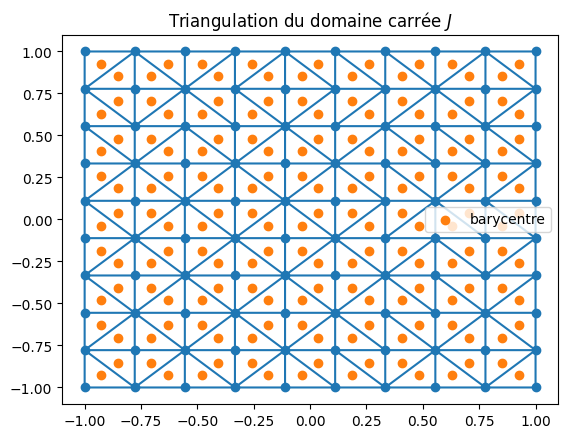

In [205]:
bar = (points[tri.simplices[:, 0], :] +
       points[tri.simplices[:, 1], :]+points[tri.simplices[:, 2], :])/3
plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(bar[:, 0], bar[:, 1], label="barycentre")
plt.title(f"Triangulation du domaine carrée $J$")
plt.legend()
plt.show()


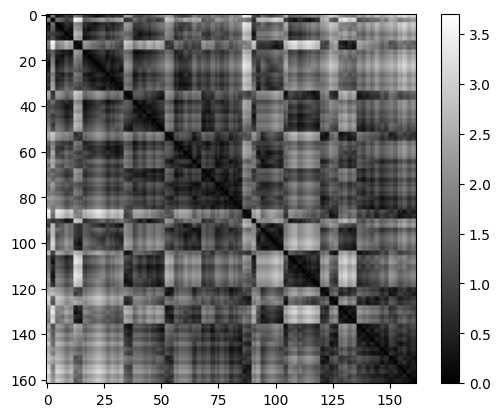

In [206]:
distMatrix = sp.distance_matrix(bar, bar, 1)
plt.imshow(distMatrix, cmap='gray', label="Distance Matrix")
plt.colorbar()
plt.show()


### Question 3 (Symétrisation du problème)

$KD \phi = \lambda \phi \Leftrightarrow D^{1/2} KD \phi =  D^{1/2} \lambda \phi \Leftrightarrow  D^{1/2} K D^{1/2} D^{1/2}\phi =   \lambda D^{1/2}\phi $ 

Posons $S_K =  D^{1/2} K D^{1/2}$ et $D^{1/2}\phi = \phi_D$, on a le problème $S_K \phi_D = \lambda \phi_D$ avec $S_k$ symétrique

In [207]:
# Calcul de D
ne = len(tri.simplices)
D = np.zeros(ne)
for k in range(0, ne):
    n1 = tri.simplices[k, 0]
    n2 = tri.simplices[k, 1]
    n3 = tri.simplices[k, 2]

    x1 = points[n1, 0]
    x2 = points[n2, 0]
    x3 = points[n3, 0]

    y1 = points[n1, 1]
    y2 = points[n2, 1]
    y3 = points[n3, 1]

    t = np.array([x2-x3, y2-y3])
    l1 = np.linalg.norm(t)

    t = np.array([x3-x1, y3-y1])
    l2 = np.linalg.norm(t)

    t = np.array([x1-x2, y1-y2])
    l3 = np.linalg.norm(t)

    p = (l1+l2+l3)/2

    D[k] = np.sqrt(p*(p-l1)*(p-l2)*(p-l3))


### Question 4 (Génération de trajectoires)

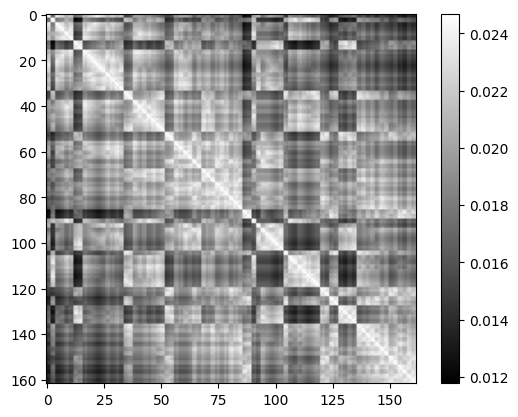

In [208]:
# calcul de Sk
Sk = np.matmul(np.diag(D**(1/2)),
               np.matmul(np.exp(- distMatrix / lambdaK), np.diag(D**(1/2))))

plt.imshow(Sk, cmap='gray')
plt.colorbar()
plt.show()


In [209]:
# Calcul des valeurs propres et vecteur propres de la matrice Sk
Skw, Skv = np.linalg.eig(Sk)

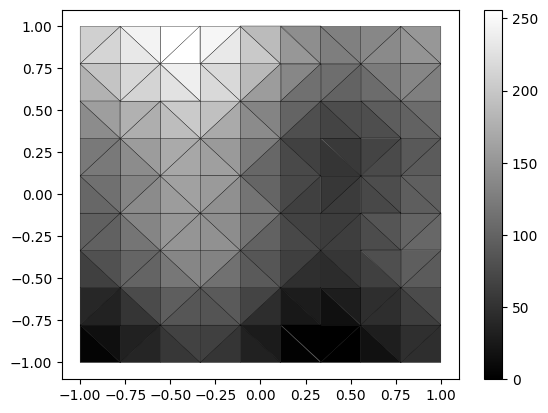

In [223]:
# Renormalisation
Skv = np.matmul(np.diag(D**(-1/2)),Skv)

# Troncature
tracehK = sum(Skw)
Nkl = sum(np.cumsum(Skw) < tracehK*partVar) + 1

SkwTronc = Skw[:Nkl]

# Calcul des trajectoires
Xin = np.random.randn(Nkl)

cn = (np.sqrt(SkwTronc)*Xin).reshape(Nkl, 1)

Phin = Skv[:, :Nkl]

ZNkl = np.matmul(Phin, cn)

#Affichage
c = ZNkl.ravel()
colors = np.int64((c - min(c))/(max(c) - min
                                (c))*256)
                                
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices,
              facecolors=colors, edgecolors='k', cmap='gray')
plt.colorbar()
plt.show()

```Python
# two triangles and one quad
cells = [
    ("triangle", tri.simplices)
]

mesh = meshio.Mesh(
    points,
    cells,
)
mesh.write(
    "foo.vtu",  # str, os.PathLike, or buffer/open file
    # file_format="vtk",  # optional if first argument is a path; inferred from extension
)

# Alternative with the same options
meshio.write_points_cells("foo.vtu", points, cells) 
```

### Question 5 (Produit tensoriel)

In [211]:
# TODO

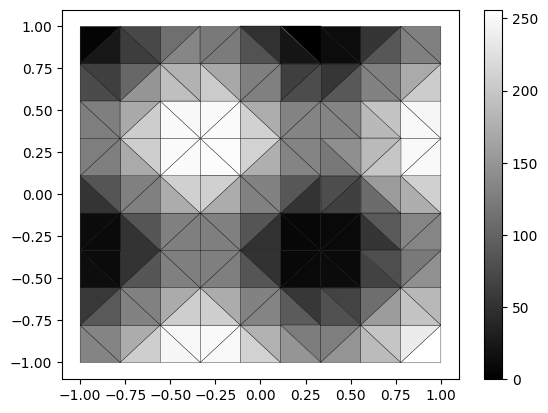

In [230]:
#Affichage
c = Phin[:,6]
colors = np.int64((c - min(c))/(max(c) - min
                                (c))*256)
                                
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices,
              facecolors=colors, edgecolors='k', cmap='gray')
plt.colorbar()
plt.show()

In [247]:
x = np.unique(np.sort(bar, 0)[:,0])

# Calcul de la matrice noyau
K = np.exp(-np.abs(np.subtract.outer(x, x)) / lambdaK)

# Calcul des valeurs propres et vecteur propres de la matrice h K
hK = h*K
hw, hv = np.linalg.eig(hK)

# Renormalisation
hv = hv / np.sqrt(h)

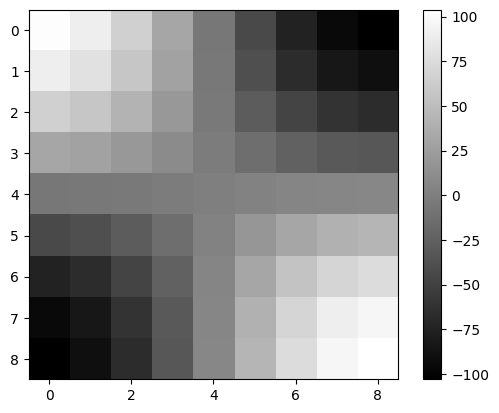

In [239]:
k = 1
l = 1                          
s1 = np.outer(hv[:,k][1::2], hv[:,l][1::2])
plt.imshow(s1, cmap = 'gray')
plt.colorbar()

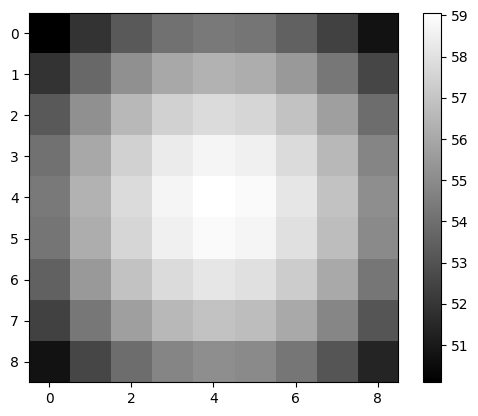

In [216]:
k = 0
l = 0                          
s1 = np.outer(hv[:,k][0::2], hv[:,l][0::2])
plt.imshow(s1, cmap = 'gray')
plt.colorbar()

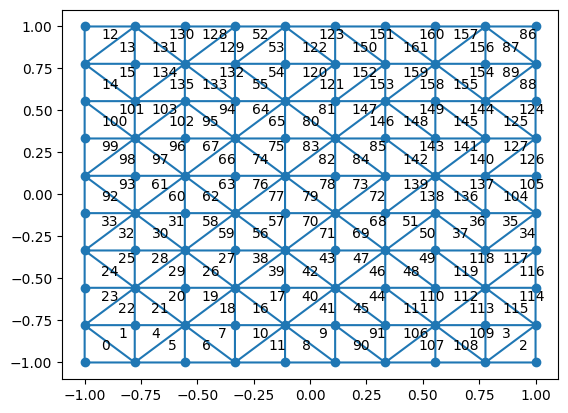

In [243]:
bar = (points[tri.simplices[:, 0], :] +
       points[tri.simplices[:, 1], :]+points[tri.simplices[:, 2], :])/3
       
plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.scatter(points[:, 0], points[:, 1])
for i in range(bar.shape[0]) :
    plt.text(bar[i, 0], bar[i, 1], "{}".format(i))
plt.show()


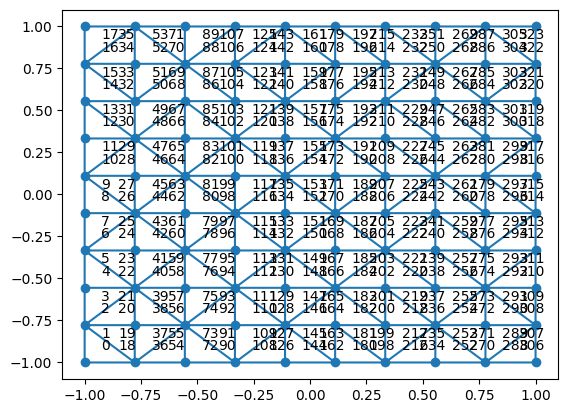

In [248]:
X = np.outer(x, np.ones(18))
Y = np.outer(x, np.ones(18))
barPoints = np.concatenate(
    (X.ravel().reshape(18*18, 1), Y.transpose().ravel().reshape(18*18, 1)), 1)

plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.scatter(points[:, 0], points[:, 1])
for i in range(barPoints.shape[0]) :
    plt.text(barPoints[i, 0], barPoints[i, 1], "{}".format(i))
plt.show()